Salma Caisaguano
Xin Yin Leong
Julia Vidarte
Estefany González

In [ ]:
# if working in colab
!pip install langid
!pip install gensim
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=0f301f64cefd1a5b597d3c679596cae2ba9f342adbda5e6cf978602ba2c3ac31
  Stored in directory: /root/.cache/pip/wheels/3c/bc/9d/266e27289b9019680d65d9b608c37bff1eff565b001c977ec5
Successfully built langid
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.0 MB/s eta 0:00:00


In [ ]:
# if working in colab
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import sys
import importlib
import langid
import ast
import gc
from tqdm import tqdm
tqdm.pandas()
from collections import defaultdict

data_folder = "/content/drive/MyDrive/Web Analytics/Final Project/Data"  # change to your working directory + 'Final Project' folder
sys.path.append(data_folder)
sys.path.append(os.path.join(data_folder, "scripts"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# if working locally
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import sys
import importlib
# import langid
import ast
import gc
from tqdm import tqdm
tqdm.pandas()
from collections import defaultdict

data_folder = os.path.join(os.getcwd(), "Data")
sys.path.append(os.path.join(data_folder, "scripts"))

### Dataset Preprocessing

Merging of the separate datasets containing obtained lyrics and fixing.

Duplicate entries on `track_id` with different lyrics are discarded.

Cross-checking of the merged dataset with the original tracks dataset and a final round of lyrics requesting is performed.

The resulting dataset is saved to `Tracks_v2.csv`.

In [ ]:
import os
import pandas as pd



# paths de los csv de lyrics
lyrics_path = [
    f"lyrics_{rango}.csv"
    for rango in ["start-5000", "5000-8000", "8000-10000", "10000-15000", "15000-end"]
]

tracks_path = os.path.join(data_folder, "Tracks_v1.csv")

# merge all csv files of obtained lyrics into one
dfs = []
for path in lyrics_path:
    dfs.append(pd.read_csv(os.path.join(data_folder, path)))

df_lyrics = pd.concat(dfs, ignore_index=True)

if 'index' in df_lyrics.columns:
    df_lyrics = df_lyrics.drop(columns=['index'])

df_lyrics = df_lyrics.sort_values(by="lyrics", na_position="last")
df_lyrics = df_lyrics.drop_duplicates(subset=["lyrics"], keep="first")

# remove duplicate entries on track_id but have different lyrics -> re-request lyrics
dupes = df_lyrics[df_lyrics.duplicated(subset="track_id", keep=False)]
duplicates_id = dupes["track_id"].unique().tolist()
df_lyrics = df_lyrics[~df_lyrics["track_id"].isin(duplicates_id)]

# merge with the original tracks to see if some tracks have been left out from the slicing
df_tracks = pd.read_csv(tracks_path)

df_tracks = df_tracks.merge(
    df_lyrics[["track_id", "lyrics"]],
    on="track_id",
    how="left"
).reset_index(drop=True)

df_tracks = df_tracks[df_tracks["track_id"].notna()]


In [ ]:
# Number of tracks to re-request
df_tracks["lyrics"].isna().sum()

9434

In [ ]:
from get_lyrics import extract_lyrics

subset_df = df_tracks[df_tracks["lyrics"].isna()]
subset_df = extract_lyrics(subset_df)

Searching for "AOT x Traitors (Hardstyle)" by [...
Done.
Searching for "SUPER SAIYAN 4D" by [...
No results found for: 'SUPER SAIYAN 4D ['
Searching for "Sasuke vs Naruto x Neutron Star Hardstyle" by [...
No results found for: 'Sasuke vs Naruto x Neutron Star Hardstyle ['
Searching for "Garou Hardstyle" by [...
No results found for: 'Garou Hardstyle ['
Searching for "goku rage for gym pr" by [...
No results found for: 'goku rage for gym pr ['
Searching for "god hand" by [...
Done.
Searching for "Sasuke Rage X House of Memories (Hardstyle)" by [...
No results found for: 'Sasuke Rage X House of Memories (Hardstyle) ['
Searching for "My Soldiers Rage" by [...
Done.
Searching for "JoJo Hardstyle" by [...
No results found for: 'JoJo Hardstyle ['
Searching for "Am I Supposed to Care Hardstyle" by [...
No results found for: 'Am I Supposed to Care Hardstyle ['
Searching for "Eren x Ya Tebya Ne Otdam (Hardstyle)" by [...
No results found for: 'Eren x Ya Tebya Ne Otdam (Hardstyle) ['
Searching f

H:\Other computers\Asus Zenbook\Degree\Y4 S1\Web Analytics\Final Project\Final Project\scripts\get_lyrics.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyrics'] = lyrics


In [ ]:
subset_df["lyrics"].isna().sum()

2135

In [ ]:
df_tracks = df_tracks.merge(
    subset_df[["track_id", "lyrics"]],
    on = "track_id",
    how = "left"
).reset_index(drop = True)

df_tracks["lyrics_x"] = df_tracks["lyrics_x"].fillna(df_tracks["lyrics_y"])
df_tracks = df_tracks.drop(columns = ["lyrics_y"]).rename(columns = {"lyrics_x": "lyrics"})
# df_tracks.to_csv(os.path.join(data_folder, "Tracks_v2.csv"), index = False)
df_tracks.isna().sum()

### Finalized Dataset - Data Preprocessing

Data cleaning (remove NAs).

Merge with dataset containing audio features (`AudioFeatures_v3.csv`) to obtain target variable "valence".

The resulting dataset is saved to `data_fv.csv`, which is the one that will be used for NLP and model training.

In [ ]:
df_tracks = pd.read_csv(os.path.join(data_folder, "Tracks_v2.csv"))
# df_tracks = df_tracks.dropna(subset = ["lyrics"])
print(len(df_tracks))
df_tracks.head()

17115


,track_name,track_id,track_artists,album_name,album_type,album_release_date,popularity,explicit_lyrics,duration_ms,lyrics
0,AOT x Traitors (Hardstyle),6HRbvWc5B3H0JX3pb5tAws,['AniLifts'],AOT x Traitors (Hardstyle),single,2022-07-01,0,False,150781.0,[Sample] (from: Attack on Titan)\n\n[Reiner]\n...
1,SUPER SAIYAN 4D,4jZcLj8ZXbJgcDZVdiux7v,['Ray Laglie'],SUPER SAIYAN 4D,single,2024-09-20,0,False,148800.0,NaN
2,Sasuke vs Naruto x Neutron Star Hardstyle,08XhTFVNStqgDjGAWsKQ08,"['AniLifts', 'Tevvez']",Sasuke vs Naruto x Neutron Star Hardstyle,single,2022-03-31,0,False,211558.0,NaN
3,Garou Hardstyle,0LQovHvMgpvl42sBnd38nN,['AniLifts'],Garou Hardstyle,single,2022-09-01,0,False,205658.0,NaN
4,goku rage for gym pr,4pC2e499wO6RyCWX9lXhyR,['fxnk123'],goku rage for gym pr,single,2023-01-28,0,False,83770.0,NaN


In [ ]:
df_audfet = pd.read_csv(os.path.join(data_folder, "AudioFeatures_v3.csv"))
# df_audfet = df_audfet.dropna(subset = ['valence'])
df_audfet.head()

,recco_name,recco_id,recco_duration,recco_popularity,recco_artist,track_id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,One Punch Man - Garou's Theme - Remix,43fdb4ff-03d4-4a34-942e-6d41643d8573,216000,31,"['Rifti Beats', 'Trap Music Now']",1rsU6NLz50e5nrCNrzVEf8,0.00956,0.783,0.468,0.944000,11.0,0.0851,-11.523,0.0,0.0390,110.009,0.461
1,Vegeta's Saiyan Pride (Vegeta vs Jiren) - Remix,a492ec9e-6dcd-4bda-8cfd-20658911a910,230687,34,"['Rifti Beats', 'Trap Music Now']",1cZ2k3aH2d5j0bMTA0xIBD,0.00798,0.570,0.551,0.898000,2.0,0.1170,-10.900,1.0,0.0303,180.050,0.629
2,goku not love its fury for gym,0723dfea-7128-43fe-86ae-5b52a8db88f1,61926,30,['fxnk123'],3uJFlUiRCssXFUu1ToF4Tr,0.02470,0.580,0.974,0.003020,9.0,0.3780,-2.992,1.0,0.0756,144.994,0.748
3,SAY IT RIGHT - Hardstyle,d2a0b752-f606-409f-a8de-1d3c6baf535b,150792,53,"['BAKI', 'ZYZZ', 'GYM HARDSTYLE']",4MFW8fi63GtwUNkLE06qH7,0.07670,0.565,0.837,0.000172,9.0,0.1690,-3.029,0.0,0.0401,147.996,0.762
4,Am I Supposed to Care Hardstyle,e7d4e030-d48c-42b7-bf01-a46e586399d5,136000,37,['MYSK'],0a1i9mtGMy7520WjOgTuWD,0.01030,0.299,0.891,0.002900,11.0,0.1080,-5.556,1.0,0.1050,205.734,0.721


In [ ]:
print(len(df_audfet))
df_audfet.isna().sum()

12411


recco_name          1
recco_id            0
recco_duration      0
recco_popularity    0
recco_artist        0
track_id            0
acousticness        6
danceability        6
energy              6
instrumentalness    6
key                 6
liveness            6
loudness            6
mode                6
speechiness         6
tempo               6
valence             6
dtype: int64

In [ ]:
track_name = set(df_tracks['track_id'].values.tolist())
recco_name = set(df_audfet['track_id'].values.tolist())
print(f"Number of tracks that exist in both datasets {len(track_name & recco_name)}")

Number of tracks that exist in both datasets 12411


Notice that we have NAs in both `df_tracks` (lyrics) and in `df_audfet` (audio features).

Any track without lyrics or without audio features are still retained to be used as test set if the need arises.

Our main data will be based on Spotify's version, so we will keep metadata from Spotify instead of ReccoBeats.

In [ ]:
print(list(df_tracks.columns))
print(list(df_audfet.columns))

['track_name', 'track_id', 'track_artists', 'album_name', 'album_type', 'album_release_date', 'popularity', 'explicit_lyrics', 'duration_ms', 'lyrics']
['recco_name', 'recco_id', 'recco_duration', 'recco_popularity', 'recco_artist', 'track_id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']


In [ ]:
t_col = ['track_id', 'track_name', 'album_type', 'album_release_date', 'popularity', 'explicit_lyrics', 'duration_ms', 'lyrics']
a_col = ['track_id', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence']
df = df_tracks[t_col].merge(
    df_audfet[a_col],
    on = ['track_id'],
    how = 'left'
)
df.head()

,track_id,track_name,album_type,album_release_date,popularity,explicit_lyrics,duration_ms,lyrics,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,6HRbvWc5B3H0JX3pb5tAws,AOT x Traitors (Hardstyle),single,2022-07-01,0,False,150781.0,[Sample] (from: Attack on Titan)\n\n[Reiner]\n...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4jZcLj8ZXbJgcDZVdiux7v,SUPER SAIYAN 4D,single,2024-09-20,0,False,148800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,08XhTFVNStqgDjGAWsKQ08,Sasuke vs Naruto x Neutron Star Hardstyle,single,2022-03-31,0,False,211558.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0LQovHvMgpvl42sBnd38nN,Garou Hardstyle,single,2022-09-01,0,False,205658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4pC2e499wO6RyCWX9lXhyR,goku rage for gym pr,single,2023-01-28,0,False,83770.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.isna().sum()

track_id                 0
track_name               1
album_type               0
album_release_date       9
popularity               0
explicit_lyrics          0
duration_ms              0
lyrics                2137
acousticness          4710
danceability          4710
energy                4710
instrumentalness      4710
key                   4710
liveness              4710
loudness              4710
mode                  4710
speechiness           4710
tempo                 4710
valence               4710
dtype: int64

Cleaning lyrics.

In [ ]:
import cleaning 
# the cleaning script has been created by us from scratch and it includes lemmatization, tokenization
# removal of basic stopwords, filtering by language, removal of genius formats ([Verse 1: ]...) with regular expressions,
# lower-case the lyrics and keeping only alphanumerical characters
importlib.reload(cleaning)
from cleaning import clean_lyrics

df = clean_lyrics(df)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Recognizing language ...


100%|██████████| 17115/17115 [19:34<00:00, 14.58it/s]


Filtering languages ...
Cleaning lyrics ...


100%|██████████| 13063/13063 [01:24<00:00, 154.96it/s]


In [ ]:
# df.to_csv(os.path.join(data_folder, 'data_fv.csv'), index = False)

# Analysis

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
import time


df = pd.read_csv(os.path.join(data_folder, 'data_fv.csv'))
df['clean_lyr'] = df['clean_lyr'].progress_apply(lambda x: ast.literal_eval(x))
#define stopwords specifically with words commonly used in songs
CUSTOM_STOP = {'oh', 'ooh', 'la', 'yeah', 'yeh', 'baby', 'na', 'ba', 'woah', 'hey', 'ah',
               'da', 'doo', 'ayy', 'wa', 'n', 'boom', 'di', 'uh', 'huh', 'whoa', 'mm', 'mmh',
               'ya', 'yah', 'dah', 'ha', 'ay', 'yuh', 'sha', 'babe', 'hmm', 'ooo', 'yo', 'oo', 'ho'}
df['clean_lyr'] = df['clean_lyr'].progress_apply(lambda X: [t for t in X if t not in CUSTOM_STOP])
#remove rows with NA values for valence, or empty lists for lyrics
df_others = df[(df['clean_lyr'].apply(len) == 0) | (df['valence'].isna())].reset_index(drop = True)
df_nlp = df[~ df['track_id'].isin(df_others['track_id'].values)].reset_index(drop = True)


print('Full dataset number of samples: ', len(df))
print('Number of samples without lyrics: ', len(df_others))
print('Number of samples with lyrics: ', len(df_nlp))

nlpT, nlpV = train_test_split(df_nlp, test_size = 0.1, random_state = 42)
Y_train = nlpT['valence'].to_numpy()   # targets
Y_valid = nlpV['valence'].to_numpy()
results = {}   # initialize dictionary to store different kinds of representations
print("Train set size: ", len(nlpT))
print("Validation set size: ", len(nlpV))
print("Preparing scaled audio features ...")
audio_features = [
    "popularity",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "mode",
    "key",
]
scaler = StandardScaler()
scaler.fit(nlpT[audio_features].values)
X_audio_T = scaler.transform(nlpT[audio_features].to_numpy())
X_audio_V = scaler.transform(nlpV[audio_features].to_numpy())

# Convert to sparse matrices
from scipy.sparse import csr_matrix
X_audio_T_sparse = csr_matrix(X_audio_T)
X_audio_V_sparse = csr_matrix(X_audio_V)
print('Done!')

100%|██████████| 13056/13056 [00:00<00:00, 19764.23it/s]


Full dataset number of samples:  13056
Number of samples without lyrics:  3618
Number of samples with lyrics:  9438
Train set size:  8494
Validation set size:  944
Preparing scaled audio features ...
Done!


## NLP - Traditional Approaches

In [ ]:
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.phrases import Phrases
from gensim.models import TfidfModel
from gensim.matutils import corpus2csc

print("Preparing corpus ...")
corpusT = nlpT['clean_lyr'].values
corpusV = nlpV['clean_lyr'].values
print("Preparing dictionary ...")
D = Dictionary(corpusT)

print("Preparing BOW ...")
bowT = [D.doc2bow(doc) for doc in corpusT]
bowV = [D.doc2bow(doc) for doc in corpusV]
print("Done!")

# save bowT and D for dashboard
# D.save(os.path.join(data_folder, 'models', 'dictionary.dict'))
# MmCorpus.serialize(os.path.join(data_folder, 'models', 'bowT.mm'), bowT)

Preparing corpus ...
Preparing dictionary ...
Preparing BOW ...
Done!


In [ ]:
#definition of baseline regressor, to be used for comparison of embedding methods
#includes both random forest and ridge regression
def perform_reg(Xt, Xv, yT, yV):

    results = {}

    print("--- Fitting Ridge ---")
    results['ridge'] = {}
    start = time.time()
    ridge = Ridge().fit(Xt,yT)
    print(f"Fitted in {time.time() - start:.2f} seconds")
    y_pred = ridge.predict(Xv)
    results['ridge']['mse'] = mean_squared_error(yV, y_pred)
    results['ridge']['mae'] = mean_absolute_error(yV, y_pred)
    results['ridge']['r2'] = r2_score(yV, y_pred)
    results['ridge']['pear'], _ = pearsonr(yV, y_pred)
    results['ridge']['sprear'], _ = spearmanr(yV, y_pred)

    print("--- Fitting RF ---")
    results['rf'] = {}
    start = time.time()
    rf = RandomForestRegressor(max_depth=2, random_state=0).fit(Xt,yT)
    print(f"Fitted in {time.time() - start:.2f} seconds")
    y_pred = rf.predict(Xv)
    results['rf']['mse'] = mean_squared_error(yV, y_pred)
    results['rf']['mae'] = mean_absolute_error(yV, y_pred)
    results['rf']['r2'] = r2_score(yV, y_pred)
    results['rf']['pear'], _ = pearsonr(yV, y_pred)
    results['rf']['sprear'], _ = spearmanr(yV, y_pred)

    # Display results
    print(f"Ridge results: {results['ridge']}")
    print(f"RF results: {results['rf']}")

    return results

import pickle as pkl



def save_checkpoint(res, file_name):
    path = os.path.join(data_folder, file_name)
    with open(path, "wb") as f:
        pkl.dump(res, f)
    print(f"Results have been saved!")

def load_checkpoint(file_name):
    path = os.path.join(data_folder, file_name)
    with open(path, "rb") as f:
        res = pkl.load(f)
    return res

def save_to_pkl(path, ob):
    with open(path, "wb") as f:
        pkl.dump(ob, f)
    print(f"Object saved to {path}")

In [10]:
# load previously obtained results to avoid rerunning models
results = load_checkpoint('results.pkl')
print("Lyrics only")
print("-----------")
for m, res in results.items():
    if 'audio' not in m:
        print(f"{m:<20} {res['ridge']['pear']}")

print()
print("Lyrics + AF")
print("-----------")
for m, res in results.items():
    if 'audio' in m:
        print(f"{m:<20} {res['ridge']['pear']}")

Lyrics only
-----------
tfidf                0.29100661156441965
tfidf_ngrams         0.30693506421551225
w2v                  0.21811568381011728
d2v                  0.25103114620555805
lda_10tops           0.22006317921255747
lda_20tops           0.2070418269328735
lda_30tops           0.22114598821154557
lda_40tops           0.20535569544308097
lda_50tops           0.2124921137750861
ldag                 0.2195163222936079
Glove                0.27924513567451825
fasttext             0.3059224143004786
ftpre                0.2385117395760858
bert_emb_ridge-rf    0.3057044236435605
roberta_emb_ridge-rf 0.30466994101295286
xlnet_emb_ridge-rf   0.2931276455477906
clean-bert_emb_ridge-rf 0.271465721727818

Lyrics + AF
-----------
tfidf_audio          0.5937148882635066
tfidf_ngrams_audio   0.6008936445075357
w2v_audio            0.6080723417725817
d2v_audio            0.613146376385388
ldag_audio           0.6111745456352563
Glove_audio          0.6132640637144211
ft_audio             

#### TF-IDF

In [ ]:

from scipy.sparse import hstack

print("Preparing TF-IDF ...")
tfidf_model = TfidfModel(bowT)
tfidfT = tfidf_model[bowT]
tfidfV = tfidf_model[bowV]

tfidfT = corpus2csc(tfidfT, num_terms=len(D)).T
tfidfV = corpus2csc(tfidfV, num_terms=len(D)).T

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO TF-IDF REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate TF-IDF representations with audio features
tfidf_audio_T = hstack([tfidfT, X_audio_T_sparse])
tfidf_audio_V = hstack([tfidfV, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['tfidf'] = perform_reg(tfidfT, tfidfV, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['tfidf_audio'] = perform_reg(tfidf_audio_T, tfidf_audio_V, Y_train, Y_valid)
print("Done!")

# ---------------------------------------------------------------
# FREE MEMORY
# ---------------------------------------------------------------
del tfidf_model
del tfidfT
del tfidfV
del tfidf_audio_T
del tfidf_audio_V
gc.collect()

Preparing TF-IDF ...
Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.09 seconds
--- Fitting RF ---
Fitted in 14.62 seconds
Ridge results: {'mse': 0.05554632796703, 'mae': 0.19250173971819504, 'r2': 0.04957045407836813, 'pear': np.float64(0.29100661156441965), 'sprear': np.float64(0.2727128020172756)}
RF results: {'mse': 0.05733342359488829, 'mae': 0.1990109592778126, 'r2': 0.018992222388380275, 'pear': np.float64(0.15548478564552376), 'sprear': np.float64(0.15563576668718998)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.21 seconds
--- Fitting RF ---
Fitted in 15.43 seconds
Ridge results: {'mse': 0.038328473373080235, 'mae': 0.15731227271418105, 'r2': 0.3441778263818184, 'pear': np.float64(0.5937148882635066), 'sprear': np.float64(0.5730460446324604)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.17247744080220437, 'r2': 0.23822649324247536, 'pear': np.float64(0.4893442433730298), 'sprear': np.fl

92

In [ ]:
print("Preparing ngrams corpus ...")
phrase_model = Phrases(corpusT, min_count=2, threshold=20)
ngrams_corpusT = [tkn for tkn in phrase_model[corpusT]]
ngrams_corpusV = [tkn for tkn in phrase_model[corpusV]]
print("Preparing Ngrams dictionary ...")
D_ngrams = Dictionary(ngrams_corpusT)

print("Preparing ngrams BOW ...")
bowT_ngrams = [D_ngrams.doc2bow(doc) for doc in ngrams_corpusT]
bowV_ngrams = [D_ngrams.doc2bow(doc) for doc in ngrams_corpusV]
print("Preparing ngrams TF-IDF ...")
tfidf_model_ngrams = TfidfModel(bowT_ngrams)
tfidfT_ngrams = tfidf_model_ngrams[bowT_ngrams]
tfidfV_ngrams = tfidf_model_ngrams[bowV_ngrams]
tfidfT_ngrams = corpus2csc(tfidfT_ngrams, num_terms=len(D_ngrams)).T
tfidfV_ngrams = corpus2csc(tfidfV_ngrams, num_terms=len(D_ngrams)).T

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO TF-IDF-NGRAMS REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate TF-IDF-NGRAMS representations with audio features
tfidf_ngrams_audio_T = hstack([tfidfT_ngrams, X_audio_T_sparse])
tfidf_ngrams_audio_V = hstack([tfidfV_ngrams, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['tfidf_ngrams'] = perform_reg(tfidfT_ngrams, tfidfV_ngrams, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['tfidf_ngrams_audio'] = perform_reg(tfidf_ngrams_audio_T, tfidf_ngrams_audio_V, Y_train, Y_valid)
print("Done!")

# delete to free up memory
del phrase_model
del ngrams_corpusT
del ngrams_corpusV
del D_ngrams
del bowT_ngrams
del bowV_ngrams
del tfidf_model_ngrams
del tfidfT_ngrams
del tfidfV_ngrams
del tfidf_ngrams_audio_T
del tfidf_ngrams_audio_V
gc.collect()

Preparing ngrams corpus ...
Preparing Ngrams dictionary ...
Preparing ngrams BOW ...
Preparing ngrams TF-IDF ...
Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.07 seconds
--- Fitting RF ---
Fitted in 12.51 seconds
Ridge results: {'mse': 0.05439670687915861, 'mae': 0.19138712284914844, 'r2': 0.06924113058422243, 'pear': np.float64(0.30693506421551225), 'sprear': np.float64(0.2827517212532914)}
RF results: {'mse': 0.057404216511571106, 'mae': 0.19923278752126533, 'r2': 0.017780914960511263, 'pear': np.float64(0.15141589582221165), 'sprear': np.float64(0.1430393083558947)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.22 seconds
--- Fitting RF ---
Fitted in 14.85 seconds
Ridge results: {'mse': 0.03771446884963961, 'mae': 0.15630125966949365, 'r2': 0.35468379611493706, 'pear': np.float64(0.6008936445075357), 'sprear': np.float64(0.5822929721993354)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.17247

92

Using Ngrams yields worse results for the case of lyrics as lyrics have repeat phrases. This causes Ngrams to blow up vocabulary size and generate noise.

#### Word2Vec

In [ ]:
from gensim.models import Word2Vec
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

class IterableSentence:
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, "r", encoding="utf8") as f:
            for line in f:
                yield line.strip().split()

def corpus_to_txtNiterable(corpus, out_path_filename):

    sentences = [row if isinstance(row, list) else [] for row in corpus]

    with open(out_path_filename, "w", encoding="utf8") as f:
        for tokens in sentences:
            f.write(" ".join(tokens) + "\n")

    sentences = IterableSentence(out_path_filename)
    return sentences

print("Preparing iterable sentences ...")
sentencesT = corpus_to_txtNiterable(corpus = corpusT, out_path_filename = os.path.join(data_folder, 'lyrics_clean_train.txt'))
sentencesV = corpus_to_txtNiterable(corpus = corpusV, out_path_filename = os.path.join(data_folder, 'lyrics_clean_valid.txt'))

def get_w2v_vector(model, sentences):
    doc_vectors = []
    for tokens in sentences:
        vectors = [model.wv[w] for w in tokens if w in model.wv]
        if len(vectors) == 0:
            vector = np.zeros(model.vector_size)
        else:
            vector = np.mean(vectors, axis = 0)
        doc_vectors.append(vector)

    return np.vstack(doc_vectors)

print("Preparing Word2Vec model ...")
w2v = Word2Vec(
    sentences = sentencesT,
    vector_size = 200,
    window = 5,
    min_count = 0,
    workers = 1,
    seed = 42
)

print("Preparing average pooled W2V embeddings ...")
w2v_T = get_w2v_vector(model = w2v, sentences = sentencesT)
w2v_V = get_w2v_vector(model = w2v, sentences = sentencesV)

print("Reduce dimsensionality")
n_components = 30
pca = PCA(n_components=n_components, random_state=42)
w2v_T_pca = pca.fit_transform(w2v_T) #fit using only training values
w2v_V_pca = pca.transform(w2v_V)

# ---------------------------------------------------------------
# ADD AUDIO FEATURES WORD2VEC REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate word2vec representations with audio features
w2v_audio_T = hstack([w2v_T_pca, X_audio_T_sparse])
w2v_audio_V = hstack([w2v_V_pca, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['w2v'] = perform_reg(w2v_T_pca, w2v_V_pca, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['w2v_audio'] = perform_reg(w2v_audio_T, w2v_audio_V, Y_train, Y_valid)
print("Done!")

Preparing iterable sentences ...
Preparing Word2Vec model ...
Preparing average pooled W2V embeddings ...
Reduce dimsensionality
Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 3.94 seconds
Ridge results: {'mse': 0.0559207104399538, 'mae': 0.19659351415336135, 'r2': 0.04316455513301942, 'pear': np.float64(0.21811568381011728), 'sprear': np.float64(0.2131354742517873)}
RF results: {'mse': 0.05726204582585165, 'mae': 0.1994851238211096, 'r2': 0.020213536975631885, 'pear': np.float64(0.14259633988385845), 'sprear': np.float64(0.14610570919757743)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.02 seconds
--- Fitting RF ---
Fitted in 5.23 seconds
Ridge results: {'mse': 0.03683775214541151, 'mae': 0.15313342719461653, 'r2': 0.36968492201467273, 'pear': np.float64(0.6080723417725817), 'sprear': np.float64(0.5820580659008072)}
RF results: {'mse': 0.04452062882990067, 'm

Time to generate TSNE plot 31.753669023513794


<function matplotlib.pyplot.show(close=None, block=None)>

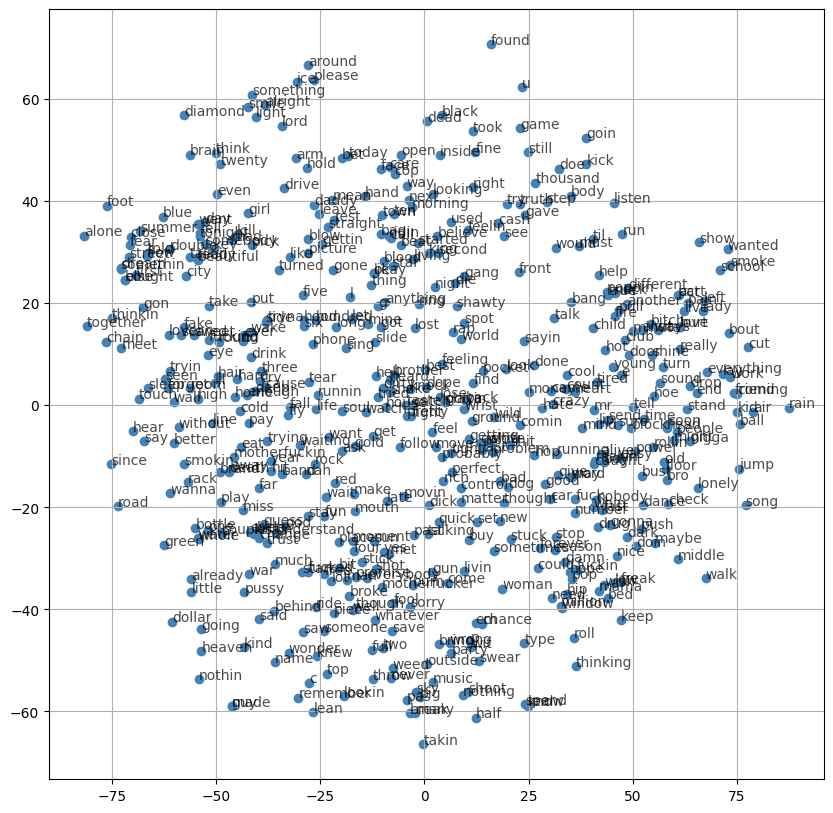

In [ ]:
from sklearn.manifold import TSNE
import  matplotlib.pyplot as plt
start_time = time.time()
tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(w2v_T)
print(f"Time to generate TSNE plot {time.time() - start_time}")
# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(10, 10))
for idx, word in enumerate((list(w2v.wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

plt.grid()
plt.show

In [ ]:
del w2v_T
del w2v_V
del w2v
del pca
del w2v_T_pca
del w2v_V_pca
del w2v_audio_T
del w2v_audio_V
del sentencesT
del sentencesV
gc.collect()

1137

#### Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def tag_corpus(corpus, prefix="DOC"):
    tagged = []
    for i, tokens in enumerate(corpus):
        if isinstance(tokens, str):
            tokens = eval(tokens)
        if tokens:
            tagged.append(TaggedDocument(words=tokens, tags=[f"{prefix}_{i}"]))
    return tagged

tagged_train = tag_corpus(corpusT, prefix="TRAIN")
tagged_val = tag_corpus(corpusV, prefix="VAL")

def get_doc_vectors(model, tagged_docs):
    vectors = []
    for doc in tagged_docs:
        vectors.append(model.dv[doc.tags[0]])
    return np.vstack(vectors)

def get_infer_vectors(model, tagged_docs):
    vectors = []
    for doc in tagged_docs:
        vec = model.infer_vector(doc.words)
        vectors.append(vec)
    return np.vstack(vectors)

print("Preparing Doc2Vec model ...")
d2v = Doc2Vec(
    vector_size=200,
    window=5,
    min_count=0,
    workers=1,
    seed=42,
    epochs=20
)
d2v.build_vocab(tagged_train)
d2v.train(tagged_train, total_examples=d2v.corpus_count, epochs=d2v.epochs)

print("Preparing average pooled D2V embeddings ...")
d2v_T = get_doc_vectors(d2v, tagged_train) #get the vectors for the documents, since they are the training ones they already exist
d2v_V = get_infer_vectors(d2v, tagged_val) #get vectors for validation dataset, based on the words contained within

print("Reduce dimsensionality")
n_components = 30
pca = PCA(n_components=n_components, random_state=42)
d2v_T_pca = pca.fit_transform(d2v_T) #fit using only training values
d2v_V_pca = pca.transform(d2v_V)

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO DOC2VEC REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate doc2vec representations with audio features
d2v_audio_T = hstack([d2v_T_pca, X_audio_T_sparse])
d2v_audio_V = hstack([d2v_V_pca, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['d2v'] = perform_reg(d2v_T_pca, d2v_V_pca, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['d2v_audio'] = perform_reg(d2v_audio_T, d2v_audio_V, Y_train, Y_valid)
print("Done!")

# delete to free up memory
del d2v_T
del d2v_V
del d2v
del pca
del d2v_T_pca
del d2v_V_pca
del d2v_audio_T
del d2v_audio_V
gc.collect()

Preparing Doc2Vec model ...
Preparing average pooled D2V embeddings ...
Reduce dimsensionality
Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 3.35 seconds
Ridge results: {'mse': 0.05559162538737298, 'mae': 0.19441340964019804, 'r2': 0.04879538922307203, 'pear': np.float64(0.25103114620555805), 'sprear': np.float64(0.23978837677883888)}
RF results: {'mse': 0.056283836964302655, 'mae': 0.19614822930988637, 'r2': 0.03695125192684112, 'pear': np.float64(0.21054740040181857), 'sprear': np.float64(0.20219950975883919)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.01 seconds
--- Fitting RF ---
Fitted in 4.67 seconds
Ridge results: {'mse': 0.036501804241289314, 'mae': 0.15217624922465023, 'r2': 0.3754331834327398, 'pear': np.float64(0.613146376385388), 'sprear': np.float64(0.587593894763799)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.17247744080220437, 'r2': 0

113389

#### LDA

LDA is done using BOW. Since Ngrams is not useful, we will use the original BOW.

This method allows visualization.

In [ ]:
from gensim.models.ldamodel import LdaModel

def get_lda_vector(model, corpus_bow):
    topic_probs_all = []
    for doc_bow in corpus_bow:
        # get topic distribution for each doc -> [(topic_id, prob), ...]
        doc_topics = model[doc_bow]
        probs = np.zeros(model.num_topics)
        # fill zeros for topics with 0 prob
        for topic_id, prob in doc_topics:
            probs[topic_id] = prob
        topic_probs_all.append(probs)
    return np.vstack(topic_probs_all)

num_topics = [10, 20, 30, 40, 50]
for t in num_topics:
    print(f"Preparing LDA model for {t} topics ...")
    ldag = LdaModel(corpus = bowT, id2word = D, num_topics = t, random_state = 42)
    print("Preparing LDA embeddings ...")
    ldaT = get_lda_vector(ldag, bowT)
    ldaV = get_lda_vector(ldag, bowV)
    print("Evaluating performance ...")
    results[f'lda_{t}tops'] = perform_reg(ldaT, ldaV, Y_train, Y_valid)
    print()
print("Done!")

del ldag
del ldaT
del ldaV
gc.collect()

Preparing LDA model for 10 topics ...
Preparing LDA embeddings ...
Evaluating performance ...
--- Fitting Ridge ---
Fitted in 0.06 seconds
--- Fitting RF ---
Fitted in 0.49 seconds
Ridge results: {'mse': 0.05573798501084543, 'mae': 0.19638165595319673, 'r2': 0.04629109207923998, 'pear': np.float64(0.22006317921255747), 'sprear': np.float64(0.1912198252222185)}
RF results: {'mse': 0.05684287233184854, 'mae': 0.19907532521619237, 'r2': 0.0273858359942859, 'pear': np.float64(0.1707815362965458), 'sprear': np.float64(0.15741777770224621)}

Preparing LDA model for 20 topics ...
Preparing LDA embeddings ...
Evaluating performance ...
--- Fitting Ridge ---
Fitted in 0.01 seconds
--- Fitting RF ---
Fitted in 0.67 seconds
Ridge results: {'mse': 0.055947648321213454, 'mae': 0.19670136277505598, 'r2': 0.04270363252677811, 'pear': np.float64(0.2070418269328735), 'sprear': np.float64(0.19439804645910172)}
RF results: {'mse': 0.05674108395172653, 'mae': 0.19837675122954734, 'r2': 0.02912749358786948

184

Preparing figures ...


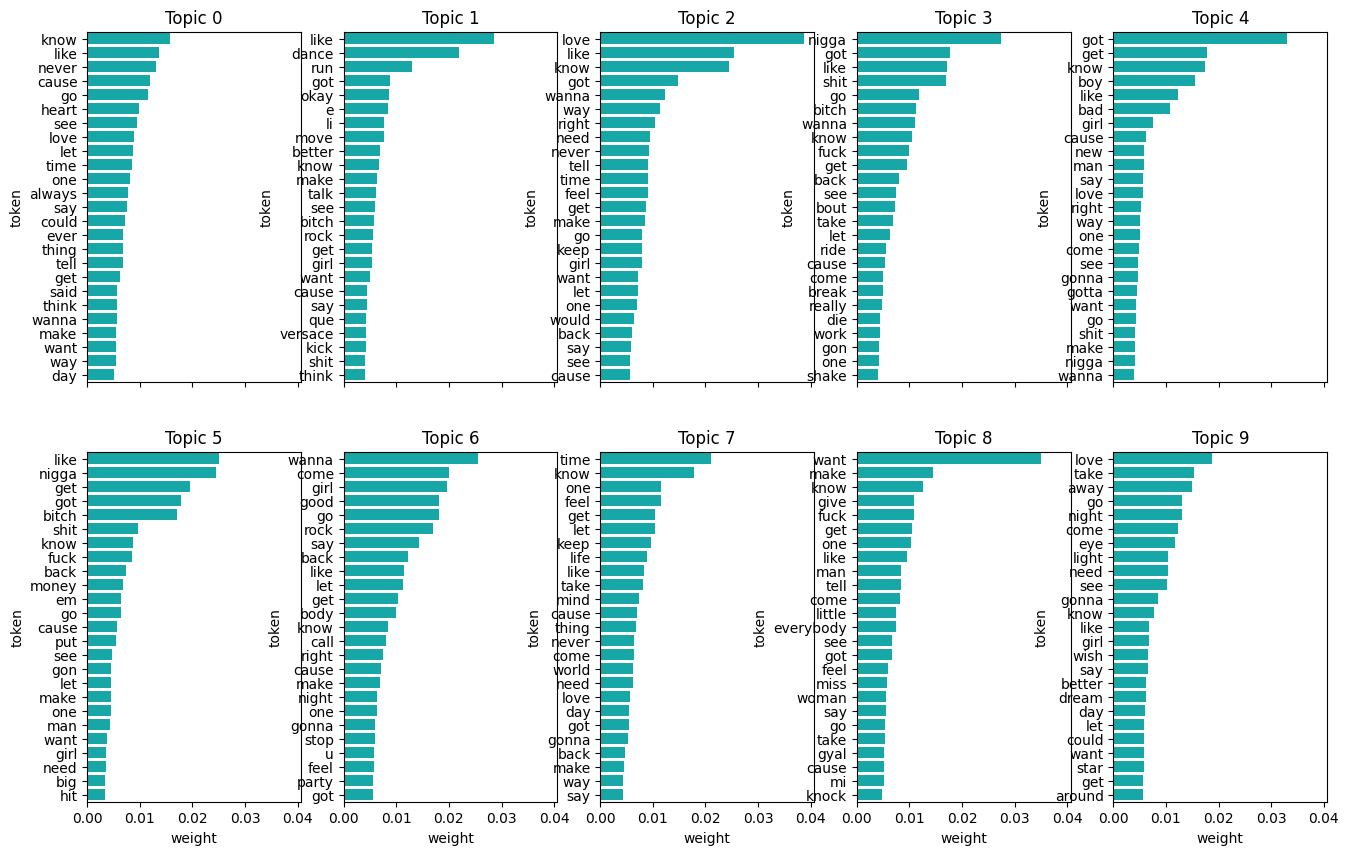

Preparing pyLDAvis ...


In [ ]:
from gensim.models.ldamodel import LdaModel
# visualization for best num_topics
ldag = LdaModel(corpus = bowT, id2word = D, num_topics = 10, random_state = 42)

topn = 25
print('Preparing figures ...')
fig, axes = plt.subplots(2, 5, figsize=(16, 10), sharex=True)
for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    topic_words = ldag.show_topic(i, topn = topn)
    df = pd.DataFrame(topic_words, columns = ['token', 'weight'])
    sns.barplot(x = 'weight', y = 'token', data = df, color = 'c', orient = 'h', ax = axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))

    # Build a dataframe with columns 'token' and 'weight' for topic i + 4
    topic_words = ldag.show_topic(i + 5, topn = topn)
    df = pd.DataFrame(topic_words, columns = ['token', 'weight'])
    sns.barplot(x = 'weight', y = 'token', data = df, color = 'c', orient = 'h', ax = axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))

plt.show()

# save ldag model
ldag.save(os.path.join(data_folder, 'models', "lda_model.gensim"))

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

print('Preparing pyLDAvis ...')
vis_data = gensimvis.prepare(ldag, bowT, D, sort_topics=False)


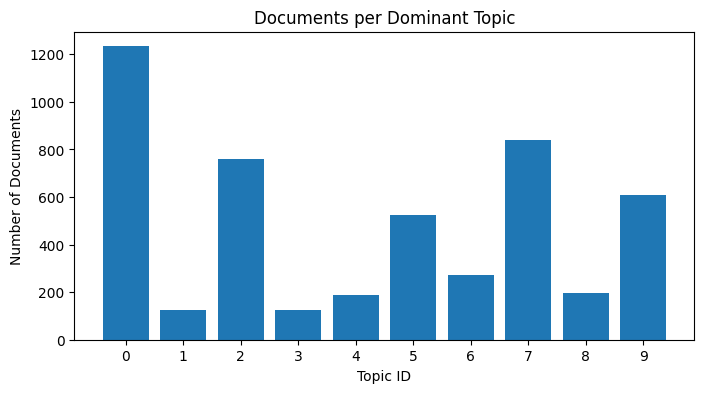

In [ ]:
dominant_topics = []

for bow in bowT:
    topic_probs = ldag.get_document_topics(bow, minimum_probability=0.0)
    # topic_probs is list of (topic_id, prob)
    dominant = max(topic_probs, key=lambda x: x[1])[0]
    dominant_topics.append(dominant + 1)   # pyldavis topics start from 1

df_lda = nlpT.copy()
df_lda['lda_dominant_topic'] = dominant_topics
df_lda.to_csv(os.path.join(data_folder, 'vis_data', 'doc_topics.csv'), index = False)

df_has_explicit = df_lda[df_lda['explicit_lyrics'] == False]
counts = df_has_explicit["lda_dominant_topic"].value_counts().sort_index()

# counts = np.bincount(dominant_topics, minlength=ldag.num_topics)
plt.figure(figsize=(8, 4))
plt.bar(range(ldag.num_topics), counts)

plt.xlabel("Topic ID")
plt.ylabel("Number of Documents")
plt.title("Documents per Dominant Topic")

plt.xticks(range(ldag.num_topics), [f"{i}" for i in range(ldag.num_topics)])
plt.show()

In [ ]:
# get lda weight of each token by topic
rel_terms = defaultdict(float)
for t_id in range(ldag.num_topics):
    for tk, w in ldag.show_topic(t_id, topn=50):
        if w > rel_terms[tk]:
            rel_terms[tk] = w

lda_terms = pd.DataFrame([{'token': tk, 'weight': w} for tk, w in rel_terms.items()])
lda_terms = lda_terms.sort_values('weight', ascending = False)
lda_terms.to_csv(os.path.join(data_folder, 'vis_data', 'lda_terms.csv'), index = False)
lda_terms.head()

,token,weight
7,love,0.038700
22,want,0.035087
29,got,0.033044
1,like,0.028483
85,nigga,0.027372


In [ ]:
html_path = os.path.join(data_folder, 'vis_data', "pyldavis.html")
pyLDAvis.save_html(vis_data, html_path)

In [ ]:
pyLDAvis.display(vis_data)

In [ ]:
ldaT = get_lda_vector(ldag, bowT)
ldaV = get_lda_vector(ldag, bowV)
# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO LDA REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate lda representations with audio features
lda_audio_T = hstack([ldaT, X_audio_T_sparse])
lda_audio_V = hstack([ldaV, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['ldag'] = perform_reg(ldaT, ldaV, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['ldag_audio'] = perform_reg(lda_audio_T, lda_audio_V, Y_train, Y_valid)
print("Done!")

del ldag
del ldaT
del ldaV
del lda_audio_T
del lda_audio_V
gc.collect()

Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 0.55 seconds
Ridge results: {'mse': 0.05574901735485946, 'mae': 0.19638283046515145, 'r2': 0.04610232234241918, 'pear': np.float64(0.2195163222936079), 'sprear': np.float64(0.19087082871111233)}
RF results: {'mse': 0.05684086306140521, 'mae': 0.19906971544580793, 'r2': 0.02742021576456022, 'pear': np.float64(0.17069411568687762), 'sprear': np.float64(0.16118470372173221)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 1.43 seconds
Ridge results: {'mse': 0.03664102185951699, 'mae': 0.1527544889783023, 'r2': 0.3730510900969759, 'pear': np.float64(0.6111745456352563), 'sprear': np.float64(0.5803783735306939)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.17247744080220437, 'r2': 0.23822649324247536, 'pear': np.float64(0.4893442433730298), 'sprear': np.float64(0.42289668505762

73749

#### GloVe

In [ ]:
from gensim import downloader
from tqdm import tqdm

def get_glove_embeddings(lyr, glove_model):
    words = lyr
    word_vectors = []

    # Get embeddings for each word
    for word in words:
        if word in glove_model:
            word_vectors.append(glove_model[word])

    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(glove_model.vector_size)

print("Downloading pretrained GloVe model...")
glove = downloader.load('glove-twitter-200')

print("Preparing average pooled GloVe embeddings ...")
glove_train_embeddings = np.array([get_glove_embeddings(lyr, glove) for lyr in tqdm(corpusT)])
glove_val_embeddings = np.array([get_glove_embeddings(lyr, glove) for lyr in tqdm(corpusV)])

print("Reduce dimensionality")
n_components = 30
pca = PCA(n_components=n_components, random_state=42)
glove_train_embeddings_pca = pca.fit_transform(glove_train_embeddings) #fit only with training values
glove_val_embeddings_pca = pca.transform(glove_val_embeddings)

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO GLOVE REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate Glove representations with audio features
glove_audio_T = hstack([glove_train_embeddings_pca, X_audio_T_sparse])
glove_audio_V = hstack([glove_val_embeddings_pca, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['Glove'] = perform_reg(glove_train_embeddings_pca, glove_val_embeddings_pca, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['Glove_audio'] = perform_reg(glove_audio_T, glove_audio_V, Y_train, Y_valid)
print("Done!")

# delete to free up memory
del glove
del glove_train_embeddings
del glove_val_embeddings
del pca
del glove_train_embeddings_pca
del glove_val_embeddings_pca
del glove_audio_T
del glove_audio_V
gc.collect()

Preparing average pooled GloVe embeddings ...


100%|██████████| 944/944 [00:00<00:00, 5018.88it/s]


Reduce dimensionality
Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.01 seconds
--- Fitting RF ---
Fitted in 3.32 seconds
Ridge results: {'mse': 0.05395611632412869, 'mae': 0.19334236612698785, 'r2': 0.07677988780689615, 'pear': np.float64(0.27924513567451825), 'sprear': np.float64(0.24442655546025266)}
RF results: {'mse': 0.05675600512357882, 'mae': 0.19827002570300065, 'r2': 0.02887218377519185, 'pear': np.float64(0.17487117416880868), 'sprear': np.float64(0.14844217634586257)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.01 seconds
--- Fitting RF ---
Fitted in 4.64 seconds
Ridge results: {'mse': 0.03647379633198647, 'mae': 0.15340082225264384, 'r2': 0.37591241483281934, 'pear': np.float64(0.6132640637144211), 'sprear': np.float64(0.5828199582862656)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.17247744080220437, 'r2': 0.23822649324247536, 'pear': np.float64(0.4893442433730298), 'sprear': np

92

#### FastText Scratch

In [ ]:
from gensim.models import FastText
import joblib

def get_ft_vector(model, tokens):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

def train_fasttext_with_early_stopping(corpusT, corpusV, Y_train, Y_valid, vector_size=200, patience=3, max_epochs=50, pca_components=30):

    models_dir = os.path.join(data_folder, "models")
    all_ft_res = {}

    print("Initializing FastText model ...")
    ft_model = FastText(vector_size=vector_size, window=5, min_count=0, workers=1, sg=1)
    ft_model.build_vocab(corpusT)

    print("Starting training ...")
    best_score = -np.inf
    best_epoch = 0
    epochs_without_improvement = 0
    for epoch in range(1, max_epochs + 1):

        print(f"\n--- Epoch {epoch} ---")
        ft_model.train(corpus_iterable=corpusT, total_examples=len(corpusT), epochs=1)

        # Compute embeddings
        ft_T = np.array([get_ft_vector(ft_model, doc) for doc in corpusT])
        ft_V = np.array([get_ft_vector(ft_model, doc) for doc in corpusV])

        # PCA
        pca = PCA(n_components=pca_components, random_state=42)
        ft_T_pca = pca.fit_transform(ft_T)
        ft_V_pca = pca.transform(ft_V)

        # Evaluate
        all_ft_res[f'ft_ep{epoch}'] = perform_reg(ft_T_pca, ft_V_pca, Y_train, Y_valid)
        pearson_score = all_ft_res[f'ft_ep{epoch}']["ridge"]["pear"]

        print(f"Validation Pearson: {pearson_score:.4f}")

        if pearson_score > best_score:
            best_score = pearson_score
            best_epoch = epoch
            epochs_without_improvement = 0

            print("Saving best model ...")
            ft_model.save(os.path.join(models_dir, "best_fasttext.model"))
            ft_model.wv.save(os.path.join(models_dir, "best_fasttext_vectors.kv"))
            joblib.dump(pca, os.path.join(models_dir, "best_pca.joblib"))
            results['fasttext'] = all_ft_res[f'ft_ep{epoch}']

        else:
            epochs_without_improvement += 1
            print(f"No improvement. Patience: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print("\nEarly stopping triggered.")
            break

        # Free memory
        del ft_T, ft_V, ft_T_pca, ft_V_pca, pca
        gc.collect()

    print(f"\nTraining completed. Best epoch = {best_epoch}, Best Pearson = {best_score:.4f}")

    return best_epoch, best_score

In [ ]:
best_epoch, best_score = train_fasttext_with_early_stopping(
    corpusT,
    corpusV,
    Y_train,
    Y_valid,
    vector_size=200,
    patience=3,
    max_epochs=30,
    pca_components=30
)

print("Best epoch:", best_epoch)
print("Best Pearson:", best_score)

Initializing FastText model ...
Starting training ...

--- Epoch 1 ---
--- Fitting Ridge ---
Fitted in 0.01 seconds
--- Fitting RF ---
Fitted in 3.38 seconds
Ridge results: {'mse': 0.056294195782233276, 'mae': 0.1975527322904538, 'r2': 0.03677400660779995, 'pear': np.float64(0.1976402309103113), 'sprear': np.float64(0.18283264072778618)}
RF results: {'mse': 0.05708425931266184, 'mae': 0.19943634797925253, 'r2': 0.023255566236365155, 'pear': np.float64(0.1578747745531101), 'sprear': np.float64(0.14689132341263472)}
Validation Pearson: 0.1976
Saving best model ...

--- Epoch 2 ---
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 3.55 seconds
Ridge results: {'mse': 0.05503332435780387, 'mae': 0.1957170469803578, 'r2': 0.058348240211456015, 'pear': np.float64(0.24473289281730873), 'sprear': np.float64(0.22964467420586274)}
RF results: {'mse': 0.0570495897067359, 'mae': 0.19910386479491962, 'r2': 0.0238487830883779, 'pear': np.float64(0.15637503325376406), 'sprear':

In [ ]:
ft_model = FastText.load(os.path.join(data_folder, 'models', "best_fasttext.model"))
ft_pca = PCA(n_components=30, random_state=42)
ft_T = np.array([get_ft_vector(ft_model, doc) for doc in corpusT])
ft_V = np.array([get_ft_vector(ft_model, doc) for doc in corpusV])
ft_T_pca = ft_pca.fit_transform(ft_T)
ft_V_pca = ft_pca.transform(ft_V)

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO Fasttext Scratch REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate Fasttext Scratch representations with audio features
ft_audio_T = hstack([ft_T_pca, X_audio_T_sparse])
ft_audio_V = hstack([ft_V_pca, X_audio_V_sparse])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics + AF ...")
results['ft_audio'] = perform_reg(ft_audio_T, ft_audio_V, Y_train, Y_valid)
print("Done!")

del ft_model
del ft_pca
del ft_T
del ft_V
del ft_T_pca
del ft_V_pca
del ft_audio_T
del ft_audio_V
gc.collect()

Adding audio features ...
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.02 seconds
--- Fitting RF ---
Fitted in 5.08 seconds
Ridge results: {'mse': 0.03574493199934483, 'mae': 0.1513588340310039, 'r2': 0.38838370181190185, 'pear': np.float64(0.6232375536576366), 'sprear': np.float64(0.5993292456975234)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.17247744080220437, 'r2': 0.23822649324247536, 'pear': np.float64(0.4893442433730298), 'sprear': np.float64(0.42289668505762557)}
Done!


46

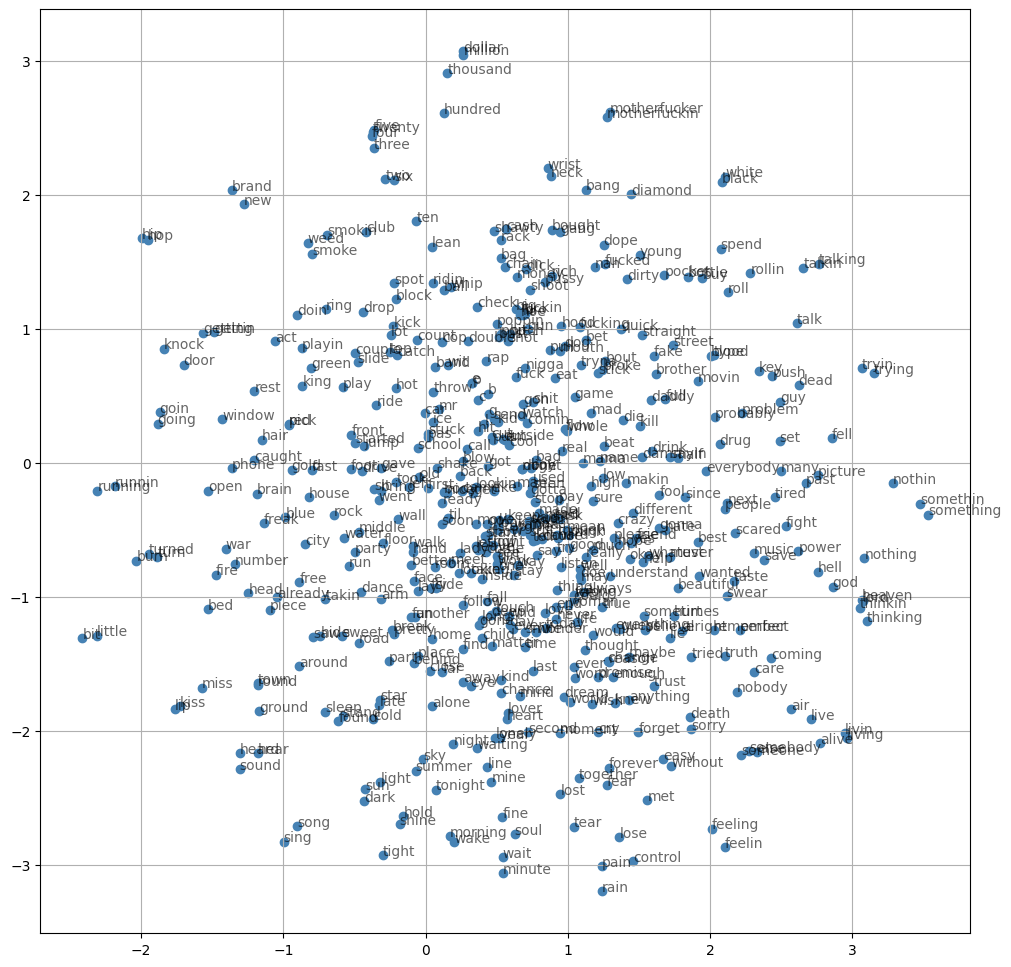

In [ ]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(os.path.join(data_folder, "models", "best_fasttext_vectors.kv"))
words = list(wv.key_to_index.keys())[:500]
X = np.array([wv[w] for w in words])
tsne = TSNE(init="random", perplexity=30, learning_rate="auto")
embed_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12, 12))
for i, word in enumerate(words):
    x, y = embed_tsne[i]
    plt.scatter(x, y, color="steelblue")
    plt.annotate(word, (x, y), alpha=0.6)

plt.grid()
plt.show()

In [ ]:
del wv
gc.collect()

64647

In [ ]:
print("Lyrics only")
print("-----------")
for m, res in results.items():
    if 'audio' not in m:
        print(f"{m:<20} {res['ridge']['pear']}")

print()
print("Lyrics + AF")
print("-----------")
for m, res in results.items():
    if 'audio' in m:
        print(f"{m:<20} {res['ridge']['pear']}")


Lyrics only
-----------
tfidf                0.29100661156441965
tfidf_ngrams         0.30693506421551225
w2v                  0.21811568381011728
d2v                  0.25103114620555805
lda_10tops           0.22006317921255747
lda_20tops           0.2070418269328735
lda_30tops           0.22114598821154557
lda_40tops           0.20535569544308097
lda_50tops           0.2124921137750861
ldag                 0.2195163222936079
Glove                0.27924513567451825
fasttext             0.3059224143004786

Lyrics + AF
-----------
tfidf_audio          0.5937148882635066
tfidf_ngrams_audio   0.6008936445075357
w2v_audio            0.6080723417725817
d2v_audio            0.613146376385388
ldag_audio           0.6111745456352563
Glove_audio          0.6132640637144211
ft_audio             0.6232375536576366


In [ ]:
# save results up to this point and move to Google Colab later to continue from here.
save_checkpoint(results, 'results.pkl')

Results have been saved!


#### FastText Pretrained

From this model on, move to colab for GPU & faster download.

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz
!pip install fasttext

--2025-12-04 17:16:12--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/cc.en.300.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-12-04 17:16:12 ERROR 403: Forbidden.



In [ ]:
from sklearn.decomposition import PCA
import fasttext
from scipy.sparse import hstack

ftpre_model = fasttext.load_model("cc.en.300.bin")
vector_dim = ftpre_model.get_dimension()

cache = {}
def get_review_vector_fast(lyr):
    vecs = []
    for w in lyr:             # create embeddings for words never seen before present in a lyric
        if w in cache:
            v = cache[w]
            if v is not None:
                vecs.append(v)
            continue

        v = ftpre_model.get_word_vector(w)
        cache[w] = v
        vecs.append(v)

    if not vecs:
        return np.zeros(vector_dim)

    return np.mean(vecs, axis=0)


def embed_corpus(corpus):
    return np.array([get_review_vector_fast(txt) for txt in tqdm(corpus)])

print("Preparing average pooled FastText-pretrained embeddings ...")
ftpre_T = embed_corpus(corpusT)
ftpre_V   = embed_corpus(corpusV)

print("Reduce dimsensionality")
n_components = 30
pca = PCA(n_components=n_components, random_state=42)
ftpre_T_pca = pca.fit_transform(ftpre_T) #fit using only training values
ftpre_V_pca = pca.transform(ftpre_V)

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO Fasttext pretrained REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate Fasttext pretrained representations with audio features
# ftpre_audio_T = hstack([ftpre_T_pca, X_audio_T_sparse])
# ftpre_audio_V = hstack([ftpre_V_pca, X_audio_V_sparse])
ftpre_audio_T = np.hstack([ftpre_T_pca, X_audio_T_sparse.toarray()])
ftpre_audio_V = np.hstack([ftpre_V_pca, X_audio_V_sparse.toarray()])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics only ...")
results['ftpre'] = perform_reg(ftpre_T_pca, ftpre_V_pca, Y_train, Y_valid)
print("Evaluating performance for lyrics + AF ...")
results['ftpre_audio'] = perform_reg(ftpre_audio_T, ftpre_audio_V, Y_train, Y_valid)
print("Done!")

del ftpre_model, ftpre_T, ftpre_V, pca, ftpre_T_pca, ftpre_V_pca, ftpre_audio_T, ftpre_audio_V
gc.collect()


Preparing average pooled FastText-pretrained embeddings ...


100%|██████████| 944/944 [00:00<00:00, 4830.96it/s]


Reduce dimsensionality
Adding audio features ...
Evaluating performance for lyrics only ...
--- Fitting Ridge ---
Fitted in 0.07 seconds
--- Fitting RF ---
Fitted in 5.67 seconds
Ridge results: {'mse': 0.05516593945145819, 'mae': 0.19544575187725535, 'r2': 0.05607911985989933, 'pear': np.float64(0.2385117395760858), 'sprear': np.float64(0.2183482897491862)}
RF results: {'mse': 0.0568686155296566, 'mae': 0.19925389657599424, 'r2': 0.026945355107451996, 'pear': np.float64(0.16449637429684383), 'sprear': np.float64(0.16230388773572213)}
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.13 seconds
--- Fitting RF ---
Fitted in 6.37 seconds
Ridge results: {'mse': 0.0369058204657689, 'mae': 0.1534134908346068, 'r2': 0.3685202339933993, 'pear': np.float64(0.6071012295485037), 'sprear': np.float64(0.5766210424713514)}
RF results: {'mse': 0.04452062882990067, 'mae': 0.1724774408022044, 'r2': 0.23822649324247536, 'pear': np.float64(0.48934424337302973), 'sprear': np.flo

92

In [ ]:
save_checkpoint(results, 'results.pkl')

Results have been saved!


### Best Traditional Model + Higher Performance Regressor

Looking at the Pearson correlation coefficient, the custom FastText model provides the best embeddings, among other traditional models.

In attempt to improve its performance on predicting valence, in this section we substitute the Ridge/RF regressor by a MLP with FiLM architecture that influences the lyrics embeddings with audio features.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import math

from transformers import (
    AutoTokenizer,
    AutoModel,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    default_data_collator,
)
from typing import Dict, List, Optional

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [14]:
# new split of data, this time split the dataset into train, test and validation

print("Preparing train, test, validation sets ...")
nlpT, nlpt = train_test_split(df_nlp, test_size = 0.1, random_state = 42)
nlpT, nlpV = train_test_split(nlpT, test_size = 0.1, random_state = 42)
print("Preparing targets ...")
train_targets = nlpT['valence'].to_numpy()
val_targets = nlpV['valence'].to_numpy()
test_targets = nlpt['valence'].to_numpy()
print("Train set size: ", len(nlpT))
print("Validation set size: ", len(nlpV))
print("Test set size: ", len(nlpt))
print()
print("Preparing texts ...")
train_texts = nlpT["clean_lyr"].tolist()
val_texts = nlpV["clean_lyr"].tolist()
test_texts = nlpt["clean_lyr"].tolist()
print("Preparing scaled audio features ...")
audio_cols = [
    "popularity",
    "acousticness",
    "danceability",
    "energy",
    "instrumentalness",
    "liveness",
    "loudness",
    "speechiness",
    "tempo",
    "mode",
    "key",
]
scaler = StandardScaler()
scaler.fit(nlpT[audio_cols].values)
train_audio = scaler.transform(nlpT[audio_cols].values)
val_audio = scaler.transform(nlpV[audio_cols].values)
test_audio = scaler.transform(nlpt[audio_cols].values)
print("Done!")
# store results
trfmr_res = {}

Preparing train, test, validation sets ...
Preparing targets ...
Train set size:  7644
Validation set size:  850
Test set size:  944

Preparing texts ...
Preparing scaled audio features ...
Done!


In [ ]:
class EmbValenceDataset(Dataset):
    """
    Dataset to use pre-calculated embeddings and audio features, 
    compatible with the Hugging Face Trainer.
    """
    def __init__(self,text_embeddings: np.ndarray, targets: List[float], audio_features: Optional[np.ndarray] = None):
        self.text_embeddings = text_embeddings
        self.targets = targets
        self.audio_features = audio_features

    def __len__(self):
        return len(self.text_embeddings)

    def __getitem__(self, idx):
        text_emb = self.text_embeddings[idx] # 30 dimensions array
        target = float(self.targets[idx])

        item = {
            "text_embeds": torch.tensor(text_emb, dtype=torch.float),
            "labels": torch.tensor(target, dtype=torch.float),
        }

        # Multimodal: Audio features
        if self.audio_features is not None:
            item["audio"] = torch.tensor(self.audio_features[idx], dtype=torch.float)

        return item

def get_ft_vector(model, tokens):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

from gensim.models import FastText

print("Preparing FastText Model ...")
ft_model = FastText.load(os.path.join(data_folder, 'models', "best_fasttext.model"), mmap=None)
ft_T = np.array([get_ft_vector(ft_model, doc) for doc in train_texts])
ft_V = np.array([get_ft_vector(ft_model, doc) for doc in val_texts])
ft_t = np.array([get_ft_vector(ft_model, doc) for doc in test_texts])
print("Preparing FastText embeddings datasets ...")
train_dataset_ft = EmbValenceDataset(
    text_embeddings=ft_T,
    targets=train_targets,
    audio_features=train_audio
)
val_dataset_ft = EmbValenceDataset(
    text_embeddings=ft_V,
    targets=val_targets,
    audio_features=val_audio
)
test_dataset_ft = EmbValenceDataset(
    text_embeddings=ft_t,
    targets=test_targets,
    audio_features=test_audio
)
audio_dim = train_audio.shape[1]
print("Done!")


Preparing FastText Model ...
Preparing FastText embeddings datasets ...
Done!


In [ ]:
class FTRegressor(nn.Module):
    def __init__(self, text_dim, audio_dim=None, dropout=0.1):
        super().__init__()

        self.audio_dim = audio_dim
        self.text_mlp = nn.Sequential(
            nn.Linear(text_dim, text_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        if audio_dim:
            self.audio_mlp = nn.Linear(audio_dim, text_dim)
            self.gamma = nn.Linear(text_dim, text_dim)
            self.beta  = nn.Linear(text_dim, text_dim)
            fusion_in = text_dim * 2
        else:
            fusion_in = text_dim

        self.final = nn.Sequential(
            nn.Linear(fusion_in, text_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(text_dim // 2, 1)
        )

    def forward(self, text_embeds=None, audio=None, labels=None):
        text_feat = self.text_mlp(text_embeds)

        if self.audio_dim:
            audio_feat = self.audio_mlp(audio)
            gamma = self.gamma(audio_feat)
            beta = self.beta(audio_feat)
            text_mod = gamma * text_feat + beta
            x = torch.cat([text_mod, audio_feat], dim=-1)
        else:
            x = text_feat

        out = self.final(x).squeeze(-1)

        if labels is not None:
            loss = F.mse_loss(out, labels.float())
            return {"loss": loss, "logits": out}

        return {"logits": out}


def compute_regression_metrics(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    mae = mean_absolute_error(labels, preds)
    rmse = math.sqrt(mean_squared_error(labels, preds))
    pearson = pearsonr(labels, preds)[0] if len(labels) > 1 else 0.0 # linear correlation between predictions and labels
    r_squared = r2_score(labels, preds)
    return {"mae": mae, "rmse": rmse, "pearson": pearson, "r_squared": r_squared}

def compute_metrics(eval_pred):
    """Wrapper for metrics."""
    preds, labels = eval_pred
    if isinstance(preds, tuple) or preds.ndim > 1:
        preds = preds.squeeze()
    metrics = compute_regression_metrics(preds, labels)
    return metrics

def run_training_ft(hf_model_ft, train_dataset, val_dataset, test_dataset, epochs=5):
    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir=os.path.join("hf_trainer"),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        learning_rate=1e-5,
        weight_decay=0.01,
        save_strategy="no",
        logging_strategy="steps",
        save_only_model=True,
        logging_steps=200,
        do_eval=True,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )

    # Define Trainer
    trainer_ft = Trainer(
        model=hf_model_ft,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # start training
    trainer_ft.train()
    val_metrics_ft = trainer_ft.evaluate()
    print("Validation metrics: ", val_metrics_ft)

    preds_output_ft = trainer_ft.predict(test_dataset)
    preds = preds_output_ft.predictions.squeeze()  # shape: (num_samples,)
    labels = preds_output_ft.label_ids
    print("Test metrics: ", preds_output_ft.metrics)

    return preds_output_ft.metrics

In [ ]:
text_dim = ft_T.shape[1]      # e.g., 300
audio_dim = train_audio.shape[1]

model_ft = FTRegressor(
    text_dim=text_dim,
    audio_dim=audio_dim,
    dropout=0.1
)
trfmr_res['ft-emb_audio_mlp'] = run_training_ft(model_ft, train_dataset_ft, val_dataset_ft, test_dataset_ft, epochs=3)

Step,Training Loss
200,0.251600
400,0.107600
600,0.060700
800,0.052300
1000,0.050400
1200,0.046800
1400,0.049300
1600,0.045200
1800,0.046600
2000,0.046800


Validation metrics:  {'eval_loss': 0.045421257615089417, 'eval_mae': 0.1714630424976349, 'eval_rmse': 0.21312263515424498, 'eval_pearson': 0.5326137542724609, 'eval_r_squared': 0.2828901410102844, 'eval_runtime': 0.8892, 'eval_samples_per_second': 955.915, 'eval_steps_per_second': 60.729, 'epoch': 3.0}
Test metrics:  {'test_loss': 0.03891231492161751, 'test_mae': 0.15818145871162415, 'test_rmse': 0.19726206521325407, 'test_pearson': 0.5789498090744019, 'test_r_squared': 0.3341878652572632, 'test_runtime': 0.3103, 'test_samples_per_second': 3041.985, 'test_steps_per_second': 190.124}


In [ ]:
save_checkpoint(trfmr_res, 'trfmr_results.pkl')

Results have been saved!


## Transformer Embeddings

### With downsteam Ridge/RF Regressor

In this sub section we first try with raw lyrics as input, then use cleaned lyrics with the best transformer encoder from the ones we have considered.
The transformer encoder weights are fixed, where we will just use it as it is.

Observation: using raw lyrics yields better performance, this could be because the custom stopwords that were removed may have been useful for the transformer encoder to pick up mood related signals.

In [6]:
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
    masked = last_hidden_state * mask
    summed = masked.sum(1)
    counts = mask.sum(1).clamp(min=1e-9)
    return summed / counts

def encode_corpus(model, tokenizer, texts, max_len, batch_size=16):
    all_embeddings = []
    device = model.device

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]

        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=max_len)
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            last_hidden = outputs.last_hidden_state
            pooled = mean_pool(last_hidden, encoded["attention_mask"])

        all_embeddings.append(pooled.cpu())

    return torch.cat(all_embeddings).numpy()

def get_transformer_emb(model_name, cT, cV, ct, max_len=256):
    print(f"Preparing transformer {model_name} ...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    print("Obtaining embeddings for training texts ...")
    T_emb = encode_corpus(model, tokenizer, cT, max_len=max_len)
    print("Obtaining embeddings for validation texts ...")
    V_emb = encode_corpus(model, tokenizer, cV, max_len=max_len)
    print("Obtaining embeddings for test texts ...")
    t_emb = encode_corpus(model, tokenizer, ct, max_len=max_len)
    return T_emb, V_emb, t_emb


#### BERT (raw lyrics)

In [ ]:
model_name = "bert-base-uncased"
cT = nlpT["lyrics"].tolist()
cV = nlpV["lyrics"].tolist()
ct = nlpt["lyrics"].tolist()

embT, embV, embt = get_transformer_emb(model_name, cT, cV, ct, max_len=512)

print("Reducing dimensionality from 768 to 30 with PCA ...")
pca = PCA(n_components=30, random_state=42)
XT = pca.fit_transform(embT)
XV = pca.transform(embV)
Xt = pca.transform(embt)
# Stack train and validation sets
XTV = np.vstack([XT, XV])
Y_TV = np.concatenate([train_targets, val_targets])

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO Bert(raw) REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate Bert(raw) representations with audio features
bert_audio_T = np.hstack([XT, train_audio])
bert_audio_V = np.hstack([XV, val_audio])
bert_audio_t = np.hstack([Xt, test_audio])
# Stack train and validation sets
bert_audio_TV = np.vstack([bert_audio_T, bert_audio_V])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics + AF ...")
results['bert_emb_ridge-rf'] = perform_reg(XTV, Xt, Y_TV, test_targets)
results['bert_emb_audio_ridge-rf'] = perform_reg(bert_audio_TV, bert_audio_t, Y_TV, test_targets)
print("Done!")

del bert_audio_T, bert_audio_V, bert_audio_t
del bert_audio_TV
del embT, embV, embt, cT, cV, ct
del pca
del XT, XV, Xt, XTV, Y_TV
gc.collect()

NameError: name 'nlpt' is not defined

#### BERT (cleaned lyrics)

In [ ]:
model_name = "bert-base-uncased"
cT = nlpT["clean_lyr"].apply(lambda x: " ".join(x)).tolist()
cV = nlpV["clean_lyr"].apply(lambda x: " ".join(x)).tolist()
ct = nlpt["clean_lyr"].apply(lambda x: " ".join(x)).tolist()

embT, embV, embt = get_transformer_emb(model_name, cT, cV, ct, max_len=256)

print("Reducing dimensionality from 768 to 30 with PCA ...")
pca = PCA(n_components=30, random_state=42)
XT = pca.fit_transform(embT)
XV = pca.transform(embV)
Xt = pca.transform(embt)
# Stack train and validation sets
XTV = np.vstack([XT, XV])
Y_TV = np.concatenate([train_targets, val_targets])

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO Bert(clean) REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate Bert(clean) representations with audio features
bert_audio_T = np.hstack([XT, train_audio])
bert_audio_V = np.hstack([XV, val_audio])
bert_audio_t = np.hstack([Xt, test_audio])
# Stack train and validation sets
bert_audio_TV = np.vstack([bert_audio_T, bert_audio_V])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics + AF ...")
results['clean-bert_emb_ridge-rf'] = perform_reg(XTV, Xt, Y_TV, test_targets)
results['clean-bert_emb_audio_ridge-rf'] = perform_reg(bert_audio_TV, bert_audio_t, Y_TV, test_targets)
print("Done!")

del bert_audio_T, bert_audio_V, bert_audio_t
del bert_audio_TV
del embT, embV, embt, cT, cV, ct
del pca
del XT, XV, Xt, XTV, Y_TV
gc.collect()

Preparing transformer bert-base-uncased ...
Obtaining embeddings for training texts ...


100%|██████████| 478/478 [01:13<00:00,  6.50it/s]


Obtaining embeddings for validation texts ...


100%|██████████| 54/54 [00:07<00:00,  6.99it/s]


Obtaining embeddings for test texts ...


100%|██████████| 59/59 [00:08<00:00,  6.87it/s]


Reducing dimensionality from 768 to 30 with PCA ...
Adding audio features ...
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 4.24 seconds
Ridge results: {'mse': 0.05413834470829801, 'mae': 0.19384154879198234, 'r2': 0.07366185558480431, 'pear': np.float64(0.271465721727818), 'sprear': np.float64(0.21682065666073944)}
RF results: {'mse': 0.05613239603852896, 'mae': 0.1984542706158154, 'r2': 0.039542493068874474, 'pear': np.float64(0.19983166327884583), 'sprear': np.float64(0.1926633947651076)}
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 4.92 seconds
Ridge results: {'mse': 0.03685754638911182, 'mae': 0.15468612703734075, 'r2': 0.36934623114633824, 'pear': np.float64(0.60777759884861), 'sprear': np.float64(0.5733263131310384)}
RF results: {'mse': 0.04448447484682653, 'mae': 0.1725287274364335, 'r2': 0.23884510863928088, 'pear': np.float64(0.4902501973286151), 'sprear': np.float64(0.42481180

3727

#### RoBERTa (raw lyrics)

In [ ]:
model_name = "roberta-base"
cT = nlpT["lyrics"].tolist()
cV = nlpV["lyrics"].tolist()
ct = nlpt["lyrics"].tolist()

embT, embV, embt = get_transformer_emb(model_name, cT, cV, ct, max_len=512)

print("Reducing dimensionality from 768 to 30 with PCA ...")
pca = PCA(n_components=30, random_state=42)
XT = pca.fit_transform(embT)
XV = pca.transform(embV)
Xt = pca.transform(embt)
# Stack train and validation sets
XTV = np.vstack([XT, XV])
Y_TV = np.concatenate([train_targets, val_targets])

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO RoBerta(raw) REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate RoBerta(raw) representations with audio features
roberta_audio_T = np.hstack([XT, train_audio])
roberta_audio_V = np.hstack([XV, val_audio])
roberta_audio_t = np.hstack([Xt, test_audio])
# Stack train and validation sets
roberta_audio_TV = np.vstack([roberta_audio_T, roberta_audio_V])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics + AF ...")
results['roberta_emb_ridge-rf'] = perform_reg(XTV, Xt, Y_TV, test_targets)
results['roberta_emb_audio_ridge-rf'] = perform_reg(roberta_audio_TV, roberta_audio_t, Y_TV, test_targets)
print("Done!")

del roberta_audio_T, roberta_audio_V, roberta_audio_t
del roberta_audio_TV
del embT, embV, embt, cT, cV, ct
del pca
del XT, XV, Xt, XTV, Y_TV
gc.collect()

Preparing transformer roberta-base ...


h:\Other computers\Asus Zenbook\Degree\Y4 S1\Web Analytics\Final Project\.venv-illegear\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

Obtaining embeddings for training texts ...


100%|██████████| 478/478 [02:25<00:00,  3.28it/s]


Obtaining embeddings for validation texts ...


100%|██████████| 54/54 [00:16<00:00,  3.25it/s]


Obtaining embeddings for test texts ...


100%|██████████| 59/59 [00:23<00:00,  2.51it/s]


Reducing dimensionality from 768 to 30 with PCA ...
Adding audio features ...
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 4.03 seconds
Ridge results: {'mse': 0.05306130707700815, 'mae': 0.19109702772278403, 'r2': 0.09209058749764865, 'pear': np.float64(0.30466994101295286), 'sprear': np.float64(0.28199385773803204)}
RF results: {'mse': 0.05489808865957079, 'mae': 0.19476604146155727, 'r2': 0.06066220061114891, 'pear': np.float64(0.24877696272972583), 'sprear': np.float64(0.22301564348868655)}
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 4.69 seconds
Ridge results: {'mse': 0.03640677957417885, 'mae': 0.15244934315677208, 'r2': 0.3770591100154431, 'pear': np.float64(0.6142727422851748), 'sprear': np.float64(0.5836598294347972)}
RF results: {'mse': 0.04448447484682653, 'mae': 0.1725287274364335, 'r2': 0.23884510863928088, 'pear': np.float64(0.49025019732861513), 'sprear': np.float64(0.424

101

#### XLNet (raw lyrics)

In [ ]:
model_name = "xlnet-base-cased"
cT = nlpT["lyrics"].tolist()
cV = nlpV["lyrics"].tolist()
ct = nlpt["lyrics"].tolist()

embT, embV, embt = get_transformer_emb(model_name, cT, cV, ct, max_len=512)

print("Reducing dimensionality from 768 to 30 with PCA ...")
pca = PCA(n_components=30, random_state=42)
XT = pca.fit_transform(embT)
XV = pca.transform(embV)
Xt = pca.transform(embt)
# Stack train and validation sets
XTV = np.vstack([XT, XV])
Y_TV = np.concatenate([train_targets, val_targets])

# ---------------------------------------------------------------
# ADD AUDIO FEATURES TO XLNet(raw) XLNet(raw) REPRESENTATIONS
# ---------------------------------------------------------------
print("Adding audio features ...")

# Concatenate XLNet(raw) representations with audio features
xlnet_audio_T = np.hstack([XT, train_audio])
xlnet_audio_V = np.hstack([XV, val_audio])
xlnet_audio_t = np.hstack([Xt, test_audio])
# Stack train and validation sets
xlnet_audio_TV = np.vstack([xlnet_audio_T, xlnet_audio_V])

# ---------------------------------------------------------------
# EVALUATE REGRESSION
# ---------------------------------------------------------------
print("Evaluating performance for lyrics + AF ...")
results['xlnet_emb_ridge-rf'] = perform_reg(XTV, Xt, Y_TV, test_targets)
results['xlnet_emb_audio_ridge-rf'] = perform_reg(xlnet_audio_TV, xlnet_audio_t, Y_TV, test_targets)
print("Done!")

del xlnet_audio_T, xlnet_audio_V, xlnet_audio_t
del xlnet_audio_TV
del embT, embV, embt, cT, cV, ct
del pca
del XT, XV, Xt, XTV, Y_TV
gc.collect()

Preparing transformer xlnet-base-cased ...


h:\Other computers\Asus Zenbook\Degree\Y4 S1\Web Analytics\Final Project\.venv-illegear\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--xlnet-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is no

Obtaining embeddings for training texts ...


100%|██████████| 478/478 [09:58<00:00,  1.25s/it]


Obtaining embeddings for validation texts ...


100%|██████████| 54/54 [01:05<00:00,  1.22s/it]


Obtaining embeddings for test texts ...


100%|██████████| 59/59 [01:13<00:00,  1.24s/it]


Reducing dimensionality from 768 to 30 with PCA ...
Adding audio features ...
Evaluating performance for lyrics + AF ...
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 4.40 seconds
Ridge results: {'mse': 0.05350225048999318, 'mae': 0.19200671890287074, 'r2': 0.0845457926728812, 'pear': np.float64(0.2931276455477906), 'sprear': np.float64(0.26258132235585846)}
RF results: {'mse': 0.05553788971283679, 'mae': 0.19671450069677662, 'r2': 0.04971483744977634, 'pear': np.float64(0.2247103499313697), 'sprear': np.float64(0.19904531841157228)}
--- Fitting Ridge ---
Fitted in 0.00 seconds
--- Fitting RF ---
Fitted in 5.18 seconds
Ridge results: {'mse': 0.03658497277635133, 'mae': 0.15388040109614035, 'r2': 0.37401012207284434, 'pear': np.float64(0.6117621412439512), 'sprear': np.float64(0.583404952356373)}
RF results: {'mse': 0.04448447484682653, 'mae': 0.1725287274364335, 'r2': 0.23884510863928088, 'pear': np.float64(0.49025019732861513), 'sprear': np.float64(0.424811

135

#### Checkpoint

In [ ]:
print("Lyrics only")
print("-----------")
for m, res in results.items():
    if 'emb' not in m:
        continue
    if 'audio' not in m:
        print(f"{m:<40} {res['ridge']['pear']}")

print()
print("Lyrics + AF")
print("-----------")
for m, res in results.items():
    if 'emb' not in m:
        continue
    if 'audio' in m:
        print(f"{m:<40} {res['ridge']['pear']}")

Lyrics only
-----------
bert_emb_ridge-rf                        0.3057044236435605
roberta_emb_ridge-rf                     0.30466994101295286
xlnet_emb_ridge-rf                       0.2931276455477906
clean-bert_emb_ridge-rf                  0.271465721727818

Lyrics + AF
-----------
bert_emb_audio_ridge-rf                  0.6119958892943818
roberta_emb_audio_ridge-rf               0.6142727422851748
xlnet_emb_audio_ridge-rf                 0.6117621412439512
clean-bert_emb_audio_ridge-rf            0.60777759884861


In [ ]:
save_checkpoint(results, 'results.pkl')

Results have been saved!


### Full Transformer

Here, we will be fine tuning the transformer encoder along with the MLP (with FiLM architecture), instead of using the encoder as it is.

In [18]:
class TransformerRegressor(nn.Module):
    def __init__(self, model_name, freeze_encoder = False, audio_dim = None, dropout = 0.1):
        super().__init__()
        self.audio_dim = audio_dim
        self.encoder = AutoModel.from_pretrained(model_name)
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        hidden = self.encoder.config.hidden_size

        self.text_mlp = nn.Sequential(
            nn.Linear(hidden, hidden)
        )
        if self.audio_dim:
            self.audio_mlp = nn.Sequential(
                nn.Linear(audio_dim, 128),
                nn.ReLU(),
                nn.Linear(128, 128)
            )
            # FiLM: audio conditions text
            self.gamma = nn.Linear(128, hidden)
            self.beta = nn.Linear(128, hidden)
            final_in = hidden + 128
        else:
            final_in = hidden

        self.final = nn.Sequential(
            nn.Linear(final_in, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask, audio = None, labels=None):
        en_out = self.encoder(input_ids = input_ids, attention_mask = attention_mask)
        # en_pooled = en_out.last_hidden_state[:, 0]
        # text_feat = self.text_mlp(en_pooled)
        hidden = en_out.last_hidden_state
        mask = attention_mask.unsqueeze(-1).float()
        text_feat = (hidden * mask).sum(dim=1) / mask.sum(dim=1)

        if self.audio_dim:
            audio_feat = self.audio_mlp(audio)
            gamma = self.gamma(audio_feat)
            beta = self.beta(audio_feat)
            text_mod = gamma * text_feat + beta
            x = torch.cat([text_mod, audio_feat], dim=-1)
        else:
            x = text_feat

        out = self.final(x).squeeze(-1)

        if labels is not None:
            loss = F.mse_loss(out, labels.float().squeeze())
            return {'loss': loss, 'logits': out}
        return {'logits': out}

class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, audio_feats=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.audio_feats = audio_feats
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.float),
        }

        if self.audio_feats is not None:
            item["audio"] = torch.tensor(self.audio_feats[idx], dtype=torch.float)

        return item

class DataCollator:
    def __call__(self, features):
        # Convert list of dict → dict of tensors
        return {k: torch.stack([f[k] for f in features]) for k in features[0]}

def compute_regression_metrics(preds, labels):
    preds = np.array(preds)
    labels = np.array(labels)
    mae = mean_absolute_error(labels, preds)
    rmse = math.sqrt(mean_squared_error(labels, preds))
    pearson = pearsonr(labels, preds)[0] if len(labels) > 1 else 0.0 # linear correlation between predictions and labels
    r_squared = r2_score(labels, preds)
    return {"mae": mae, "rmse": rmse, "pearson": pearson, "r_squared": r_squared}

def compute_metrics(eval_pred):
    """Wrapper for metrics."""
    preds, labels = eval_pred
    if isinstance(preds, tuple) or preds.ndim > 1:
        preds = preds.squeeze()
    metrics = compute_regression_metrics(preds, labels)
    return metrics

def run_training(hf_model, train_dataset, val_dataset, test_dataset, epochs=5, return_preds = False):
    training_args = TrainingArguments(
        output_dir=os.path.join('hf_trainer'),
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        learning_rate=1e-5,
        weight_decay=0.01,
        # warmup_ratio=0.05,
        # metric_for_best_model="pearson",
        # greater_is_better=True,
        save_strategy="no",
        logging_strategy="steps",
        save_only_model=True,
        logging_steps=200,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    collator = DataCollator()

    trainer = Trainer(
        model=hf_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    val_metrics = trainer.evaluate()
    print("Validation metrics:", val_metrics)

    preds_output = trainer.predict(test_dataset)
    print("Test metrics:", preds_output.metrics)

    if return_preds:
      return preds_output
    return preds_output.metrics



#### BERT

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
cT = nlpT["lyrics"].tolist()
cV = nlpV["lyrics"].tolist()
ct = nlpt["lyrics"].tolist()
print("Preparing lyrics datasets ...")
datasetT = LyricsDataset(cT, train_targets, tokenizer, train_audio)
datasetV = LyricsDataset(cV, val_targets, tokenizer, val_audio)
datasett = LyricsDataset(ct, test_targets, tokenizer, test_audio)
print("Initializing transformer for lyrics only ...")
model = TransformerRegressor(model_name, freeze_encoder = False, audio_dim = None, dropout=0.1)
trfmr_res['raw-bert'] = run_training(model, datasetT, datasetV, datasett, epochs=3)

Preparing lyrics datasets ...
Initializing transformer for lyrics only ...


Step,Training Loss
200,0.064100
400,0.060500
600,0.060100
800,0.058300
1000,0.056600
1200,0.052100
1400,0.052000
1600,0.050800
1800,0.051700
2000,0.049900


Validation metrics: {'eval_loss': 0.05720381811261177, 'eval_mae': 0.19207482039928436, 'eval_rmse': 0.23917319689424182, 'eval_pearson': 0.36769673228263855, 'eval_r_squared': 0.0968673825263977, 'eval_runtime': 4.4199, 'eval_samples_per_second': 192.311, 'eval_steps_per_second': 12.217, 'epoch': 3.0}
Test metrics: {'test_loss': 0.05024287477135658, 'test_mae': 0.1828812062740326, 'test_rmse': 0.22414924926759733, 'test_pearson': 0.4102321267127991, 'test_r_squared': 0.14031541347503662, 'test_runtime': 4.978, 'test_samples_per_second': 189.633, 'test_steps_per_second': 11.852}


In [ ]:
print("Initializing transformer for lyrics  + AF ...")
model = TransformerRegressor(model_name, freeze_encoder = False, audio_dim = train_audio.shape[1], dropout=0.1)
trfmr_res['raw-bert_audio'] = run_training(model, datasetT, datasetV, datasett, epochs=3)

Initializing transformer for lyrics  + AF ...


Step,Training Loss
200,0.073100
400,0.046400
600,0.045100
800,0.043200
1000,0.043900
1200,0.040500
1400,0.042700
1600,0.038900
1800,0.041100
2000,0.041300


Validation metrics: {'eval_loss': 0.03917424753308296, 'eval_mae': 0.1586732268333435, 'eval_rmse': 0.1979248532475974, 'eval_pearson': 0.6188046336174011, 'eval_r_squared': 0.38151782751083374, 'eval_runtime': 4.3749, 'eval_samples_per_second': 194.29, 'eval_steps_per_second': 12.343, 'epoch': 3.0}
Test metrics: {'test_loss': 0.034997422248125076, 'test_mae': 0.1479257196187973, 'test_rmse': 0.18707597988016814, 'test_pearson': 0.6360665559768677, 'test_r_squared': 0.40117400884628296, 'test_runtime': 4.8527, 'test_samples_per_second': 194.53, 'test_steps_per_second': 12.158}


In [ ]:
del datasetT, datasetV, datasett, cT, cV, ct, tokenizer, model

#### RoBERTa

In [ ]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
cT = nlpT["lyrics"].tolist()
cV = nlpV["lyrics"].tolist()
ct = nlpt["lyrics"].tolist()
print("Preparing lyrics datasets ...")
datasetT = LyricsDataset(cT, train_targets, tokenizer, train_audio)
datasetV = LyricsDataset(cV, val_targets, tokenizer, val_audio)
datasett = LyricsDataset(ct, test_targets, tokenizer, test_audio)
print("Initializing transformer for lyrics only ...")
model = TransformerRegressor(model_name, freeze_encoder = False, audio_dim = None, dropout=0.1)
trfmr_res['raw-roberta'] = run_training(model, datasetT, datasetV, datasett, epochs=3)

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /roberta-base/resolve/main/tokenizer_config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))"), '(Request ID: e38161d5-1641-43c1-bb03-cc64b2aaea96)')' thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Preparing lyrics datasets ...
Initializing transformer for lyrics only ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.062100
400,0.061800
600,0.060200
800,0.058100
1000,0.056800
1200,0.052400
1400,0.051700
1600,0.052300
1800,0.052000
2000,0.050100


Validation metrics: {'eval_loss': 0.0576571561396122, 'eval_mae': 0.19173263013362885, 'eval_rmse': 0.2401190457660787, 'eval_pearson': 0.3676564395427704, 'eval_r_squared': 0.0897100567817688, 'eval_runtime': 4.0917, 'eval_samples_per_second': 207.74, 'eval_steps_per_second': 13.198, 'epoch': 3.0}
Test metrics: {'test_loss': 0.051552388817071915, 'test_mae': 0.1833639144897461, 'test_rmse': 0.22705151137367907, 'test_pearson': 0.39938515424728394, 'test_r_squared': 0.1179090142250061, 'test_runtime': 4.7061, 'test_samples_per_second': 200.592, 'test_steps_per_second': 12.537}


In [ ]:
print("Initializing transformer for lyrics  + AF ...")
model = TransformerRegressor(model_name, freeze_encoder = False, audio_dim = train_audio.shape[1], dropout=0.1)
trfmr_res['raw-roberta_audio'] = run_training(model, datasetT, datasetV, datasett, epochs=3)

Initializing transformer for lyrics  + AF ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.074300
400,0.046200
600,0.045000
800,0.044200
1000,0.044000
1200,0.039600
1400,0.040700
1600,0.038600
1800,0.040500
2000,0.039500


Validation metrics: {'eval_loss': 0.04165502265095711, 'eval_mae': 0.16178378462791443, 'eval_rmse': 0.20409562134195117, 'eval_pearson': 0.5987300872802734, 'eval_r_squared': 0.34235143661499023, 'eval_runtime': 4.3845, 'eval_samples_per_second': 193.863, 'eval_steps_per_second': 12.316, 'epoch': 3.0}
Test metrics: {'test_loss': 0.036126717925071716, 'test_mae': 0.14919526875019073, 'test_rmse': 0.19007029732462596, 'test_pearson': 0.6347817182540894, 'test_r_squared': 0.38185107707977295, 'test_runtime': 4.8196, 'test_samples_per_second': 195.868, 'test_steps_per_second': 12.242}


In [ ]:
del datasetT, datasetV, datasett, cT, cV, ct, tokenizer, model

#### XLNet

In [16]:
model_name = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
cT = nlpT["lyrics"].tolist()
cV = nlpV["lyrics"].tolist()
ct = nlpt["lyrics"].tolist()
print("Preparing lyrics datasets ...")
datasetT = LyricsDataset(cT, train_targets, tokenizer, train_audio)
datasetV = LyricsDataset(cV, val_targets, tokenizer, val_audio)
datasett = LyricsDataset(ct, test_targets, tokenizer, test_audio)
print("Initializing transformer for lyrics only ...")
model = TransformerRegressor(model_name, freeze_encoder = False, audio_dim = None, dropout=0.1)
trfmr_res['raw-xlnet'] = run_training(model, datasetT, datasetV, datasett, epochs=3)

Preparing lyrics datasets ...
Initializing transformer for lyrics only ...


pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Step,Training Loss
200,0.171200
400,0.064500
600,0.062900
800,0.061900
1000,0.061100
1200,0.057900
1400,0.055700
1600,0.056000
1800,0.056800
2000,0.055000


Validation metrics: {'eval_loss': 0.05819932371377945, 'eval_mae': 0.19317792356014252, 'eval_rmse': 0.24124535226297966, 'eval_pearson': 0.357302188873291, 'eval_r_squared': 0.08115041255950928, 'eval_runtime': 7.7259, 'eval_samples_per_second': 110.019, 'eval_steps_per_second': 6.989, 'epoch': 3.0}
Test metrics: {'test_loss': 0.05230894684791565, 'test_mae': 0.1862822026014328, 'test_rmse': 0.2287114926013025, 'test_pearson': 0.39126676321029663, 'test_r_squared': 0.10496389865875244, 'test_runtime': 7.9458, 'test_samples_per_second': 118.805, 'test_steps_per_second': 7.425}


In [19]:
print("Initializing transformer for lyrics  + AF ...")
model = TransformerRegressor(model_name, freeze_encoder = False, audio_dim = train_audio.shape[1], dropout=0.1)
#trfmr_res['raw-xlnet_audio'] = run_training(model, datasetT, datasetV, datasett, epochs=3)
pred_final = run_training(model, datasetT, datasetV, datasett, epochs=3, return_preds = True)

#del datasetT, datasetV, datasett, cT, cV, ct, tokenizer, model

Initializing transformer for lyrics  + AF ...


Step,Training Loss
200,0.064500
400,0.049200
600,0.046000
800,0.044800
1000,0.042600
1200,0.039600
1400,0.041300
1600,0.038400
1800,0.039800
2000,0.039000


Validation metrics: {'eval_loss': 0.03973902016878128, 'eval_mae': 0.15742450952529907, 'eval_rmse': 0.19934648270983182, 'eval_pearson': 0.6212546825408936, 'eval_r_squared': 0.3726012110710144, 'eval_runtime': 7.687, 'eval_samples_per_second': 110.576, 'eval_steps_per_second': 7.025, 'epoch': 3.0}
Test metrics: {'test_loss': 0.035852499306201935, 'test_mae': 0.1487686038017273, 'test_rmse': 0.18934756218711118, 'test_pearson': 0.6408626437187195, 'test_r_squared': 0.3865431547164917, 'test_runtime': 8.5344, 'test_samples_per_second': 110.612, 'test_steps_per_second': 6.913}


In [34]:
test_song_names = nlpt['track_name'].tolist()
test_artist_names = nlpt['track_name'].tolist()

df_preds_valence = pd.DataFrame({
    'song_name': test_song_names,
    'valence_prediction': test_predictions_lyrics
})
# Save to csv for dashboard
df_preds_valence

,song_name,valence_prediction
0,Rumors (feat. Lil Durk),0.484863
1,Bulletproof,0.481934
2,The Largest,0.691406
3,Kill Em With Kindness,0.637207
4,I'm on My Way,0.714844
...,...,...
939,Boyz Don't Cry,0.660645
940,Infinite,0.434082
941,Can We Talk,0.714355
942,FK AROUND,0.342773


In [ ]:
file_path = os.path.join(data_folder, 'vis_data', 'preds_valence.csv')
df_preds_valence.to_csv(file_path, index=False, encoding='utf-8')

#### Save Checkpoint

In [ ]:
save_checkpoint(trfmr_res, 'trfmr_res.pkl')

Results have been saved!


In [ ]:
print("Lyrics only")
print("-----------")
for m, res in trfmr_res.items():
    if 'audio' not in m:
        print(f"{m:<40} {res['test_pearson']}")

print()
print("Lyrics + AF")
print("-----------")
for m, res in trfmr_res.items():
    if 'audio' in m:
        print(f"{m:<40} {res['test_pearson']}")

Lyrics only
-----------
raw-bert                                 0.4102321267127991
raw-roberta                              0.39938515424728394
raw-xlnet                                0.3618996739387512

Lyrics + AF
-----------
raw-bert_audio                           0.6360665559768677
raw-roberta_audio                        0.6347817182540894
raw-xlnet_audio                          0.6399131417274475
ft-emb_audio_mlp                         0.5789498090744019
